In [30]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scripts.cell_model_batch_culture import *
from scripts.batch_culture_simulation import *
import os
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination

Defining and importing base parameters

In [31]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 20000; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = 4.180555555555556e+22; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
M0 = 1e8 

Defining the system topology parameters

In [32]:
#choosing the product transport method. 1 indicates this method is included
lin_trans      = 1
Tp_trans       = 0
T_trans        = 0
diff_trans     = 0

#mutaually exclusive; only one of these can be 1, rest must be 0
eprodtox       = 1
elongationtox  = 0

topology = [lin_trans, Tp_trans, T_trans, diff_trans, eprodtox, elongationtox]

creating the host and engineered parameter arrays

In [33]:
base_params = [xS0, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol, leaky_control=False)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
# 0     1       2       3       4         5        6        7           8
#[w0,   wE,     wEp,    wTF,    wpTox,    wTp,     k_Ep,    Km_Ep,      k_Tp,
#   9      10             11                 12
# # Km_Tp, a_energy_pTox, a_elongation_pTox, K_E, 
#   13      14      15       16       17   18
# # K_pTox, kdiffP, VolCell, VolCult, ksf, ksr]

Setting specific circuit parameters

In [34]:
wT = 20; wE = 20; wEp = 20; wTF = 20; wpTox = 2;
K_E = 0.3; K_pTox = 1.0

xPR[[1, 2, 3, 4, 5, 13, 14]] = [wT, wE, wEp, wTF, wpTox, K_E, K_pTox]

param_indices = [1, 2, 3, 4, 5]             # e.g., wEp at index 2 (old behaviour)
# param_indices = [2, 3, 12]    # Example: optimize wEp, wTF, K_E
lower_bounds  = [0, 0, 0, 0, 0]             # lower bounds for each parameter
upper_bounds  = [100, 100, 100, 100, 100]           # upper bounds

n_params = len(param_indices)

Writing a wrapper to take wEp and return the productivity and yield

In [35]:
def evaluate_model(x_vector):
    xPR_local = xPR.copy()
    for idx, value in zip(param_indices, x_vector):
        xPR_local[idx] = value

    vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)

    return -np.log(vP), -np.log(pY)

Setting up the optimisation problems

In [36]:
class SingleObjective(ElementwiseProblem):
    def __init__(self, obj_id):
        super().__init__(n_var=n_params,
                         n_obj=1,
                         xl=lower_bounds,
                         xu=upper_bounds)
        self.obj_id = obj_id

    def _evaluate(self, x, out):
        obj_vec = evaluate_model(x)
        out["F"] = obj_vec[self.obj_id]


class MultiObjectiveScaled(ElementwiseProblem):
    def __init__(self, scale):
        super().__init__(n_var=n_params,
                         n_obj=2,
                         xl=lower_bounds,
                         xu=upper_bounds)
        self.scale = scale

    def _evaluate(self, x, out):
        vP_log, pY_log = evaluate_model(x)
        out["F"] = np.array([vP_log, pY_log]) / self.scale

Running the optimisation to find optimal vP

In [37]:
res_vP = minimize(
    SingleObjective(obj_id=0),
    GA(pop_size=30),
    seed=1,
    verbose=True
)
max_vP_log = res_vP.F[0]
print("Max vP:", np.exp(-max_vP_log))

ValueError: operands could not be broadcast together with shapes (5,) (4,) 

Running the optimisation to find optimisal pY

In [ ]:
res_pY = minimize(
    SingleObjective(obj_id=1),
    GA(pop_size=30),
    seed=1,
    verbose=True
)
max_pY_log = res_pY.F[0]
print("Max pY:", np.exp(-max_pY_log))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 |  0.7389843861 |  0.0109423506
     2 |       60 |  0.2522639850 |  0.0108672762
     3 |       90 |  0.0322132688 |  0.0045838158
     4 |      120 |  0.0109121471 |  0.0045838158
     5 |      150 |  0.0080979595 |  0.0039700788
     6 |      180 |  0.0068491128 |  0.0039700788
     7 |      210 |  0.0060082829 |  0.0036836697
     8 |      240 |  0.0050973844 |  0.0036836697
     9 |      270 |  0.0042646247 |  0.0035846750
    10 |      300 |  0.0039438135 |  0.0035846750
    11 |      330 |  0.0037683568 |  0.0035436191
    12 |      360 |  0.0036541253 |  0.0034542293
    13 |      390 |  0.0035707294 |  0.0034107188
    14 |      420 |  0.0035422113 |  0.0034107188
    15 |      450 |  0.0035071094 |  0.0034106406
    16 |      480 |  0.0034679946 |  0.0034056680
    17 |      510 |  0.0034330050 |  0.0034056680
    18 |      540 |  0.0034033108 |  0.0032233250
    19 |      570 |  0.0033747826 |  0.0032233250


Running the multiobjective optimisation

In [ ]:
scale = np.array([abs(max_vP_log), abs(max_pY_log)])
termination = get_termination("n_gen", 80)
res = minimize(
    MultiObjectiveScaled(scale),
    NSGA2(pop_size=60),
    termination,
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       60 |      9 |             - |             -
     2 |      120 |     14 |  0.0048419531 |         ideal
     3 |      180 |     20 |  0.0117697602 |         ideal
     4 |      240 |     12 |  0.0104177594 |         ideal
     5 |      300 |     23 |  0.0084938136 |         ideal
     6 |      360 |     28 |  0.0188939329 |             f
     7 |      420 |     26 |  0.0081049022 |         ideal
     8 |      480 |     34 |  0.1348076456 |         nadir
     9 |      540 |     45 |  0.0274046775 |         nadir
    10 |      600 |     58 |  0.0051701324 |         ideal
    11 |      660 |     60 |  0.0030653545 |         ideal
    12 |      720 |     60 |  0.0047990796 |             f
    13 |      780 |     60 |  0.1661963917 |         nadir
    14 |      840 |     60 |  0.4781536963 |         nadir
    15 |      900 |     60 |  0.0026794994 |         ideal
    16 |      960 |     60 |  0.0037736467 |            

Extracting the pareto front

In [ ]:
pareto_X = res.X                          # parameter sets
pareto_scaled = res.F                     # scaled objectives
pareto_unscaled = pareto_scaled * scale   # real objectives

vP_vals = np.exp(-pareto_unscaled[:, 0])
pY_vals = np.exp(-pareto_unscaled[:, 1])

print("Pareto points:", len(vP_vals))

Pareto points: 60


In [ ]:
print(pareto_X)

[[9.99911072e+01 4.04622872e-02 1.34164776e+01 3.07311461e-03]
 [9.99658671e+01 4.61073603e+00 9.10145425e+00 3.09078420e-02]
 [9.99639037e+01 9.72432853e-01 1.69317174e+01 2.88806005e-03]
 [9.99559057e+01 5.13702117e-02 1.34164776e+01 4.99420612e-03]
 [9.99118026e+01 3.28916505e-01 2.33714875e+01 3.40376335e-02]
 [9.93216837e+01 3.52775569e+00 1.34230987e+01 2.96376586e-03]
 [9.98122748e+01 8.98299556e-01 2.27584409e+01 2.16691594e-02]
 [9.92876275e+01 2.03083318e+00 1.28586655e+01 2.96376586e-03]
 [9.99658671e+01 4.61073603e+00 1.42167073e+01 3.09078420e-02]
 [9.99659931e+01 1.44142395e-01 1.68254418e+01 4.98073773e-03]
 [9.98703099e+01 1.11893018e-01 1.46614473e+01 2.49936871e-02]
 [9.93136472e+01 6.23942695e+00 1.48037736e+01 1.00092118e-03]
 [9.98979968e+01 1.34546912e+00 1.14422848e+01 1.79964302e-01]
 [9.99676886e+01 3.52775569e+00 1.33863918e+01 9.81365460e-03]
 [9.89811916e+01 2.83302875e+00 1.34085910e+01 5.59409556e-02]
 [9.11108755e+01 2.10200852e-01 1.15703830e+01 2.166915

Now plotting the pareto front

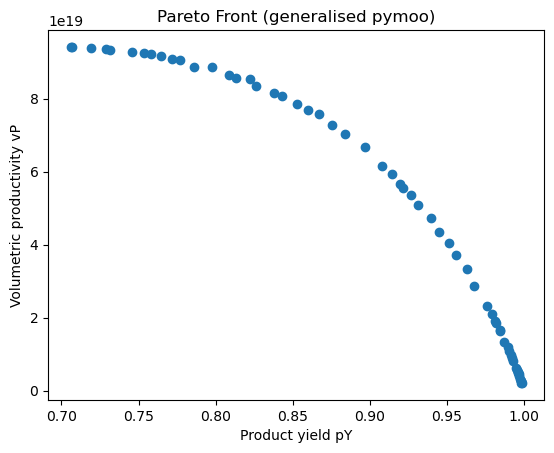

In [ ]:
plt.scatter(pY_vals, vP_vals)
plt.xlabel("Product yield pY")
plt.ylabel("Volumetric productivity vP")
plt.title("Pareto Front (generalised pymoo)")
plt.show()